In [216]:
# Computational Physics Project 4 - Molecular Orbital Theory
# Ben Zager, Zach Faber-Manning, Michael Rosen

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.linalg import eigh,solve,norm

np.set_printoptions(precision=3)


In [217]:
# import Huckel matrices (adjacency matrix of carbon chain)

buta = np.loadtxt("butadiene.txt")
benz = np.loadtxt("benzene.txt")
tolu = np.loadtxt("toluene.txt")
naph = np.loadtxt("naphthalene.txt")
ethy = np.loadtxt("ethylene.txt")
buck = np.loadtxt("buckyball.txt")

In [218]:
# Select molecule

adj = benz

N = adj.shape[0] # number of carbons
Ne = N # number of pi electrons
db = 3 # number of double bonds (2 for butadiene, 3 for benzene/toluene, 5 for naphthalene, 30 for buckyball)

In [219]:
# Compute eigenvalues and eigenvectors

# gram schmidt method to orthonormalize eigenvectors
# M is a matrix with each column an eigenvector, V is new matrix
# adapted from andreask.cs.illinois.edu/cs357-s15/public/demos/05-orthgonality/Gram-Schmidt%20and%20Modified%20Gram-Schmidt.py
def gramSchmidt(M):
    n = M.shape[0]
    V = np.zeros([n,n])
    V[:,0] = M[:,0] / norm(M[:,0])

    for i in range(n):
        q = M[:,i]
        for j in range(i):
            q = q - np.dot(q,V[:,j])*V[:,j]
    
        V[:,i] = q/norm(q)
        
    return V
    

# Finds eigenvalues and eigenvectors
# args: adjacency matrix
# rets: tuple, (eigenvalues,eigenvectors) 
def getEigs(adj):
    eigs = eigh(adj)
    evals = np.flip(np.around(eigs[0],4),0) # eigenvalues
    evecs = np.flip(np.around(eigs[1],4),1) # eigenvectors
    
    evecs = gramSchmidt(evecs) # orthogonalize eigenvectors
    
    return (evals,evecs)

evals,evecs = getEigs(adj)

print("Eigenvalues\n")
for i in range(N):
    print(str(i+1)+" : a + "+str(np.around(evals[i],3))+"b  " + str(np.around(evecs[:,i],3)))


Eigenvalues

1 : a + 2.0b  [-0.408 -0.408 -0.408 -0.408 -0.408 -0.408]
2 : a + 1.0b  [ 0.577  0.289 -0.289 -0.577 -0.289  0.289]
3 : a + 1.0b  [ 0.  -0.5 -0.5  0.   0.5  0.5]
4 : a + -1.0b  [ 0.   0.5 -0.5  0.   0.5 -0.5]
5 : a + -1.0b  [ 0.577 -0.289 -0.289  0.577 -0.289 -0.289]
6 : a + -2.0b  [ 0.408 -0.408  0.408 -0.408  0.408 -0.408]


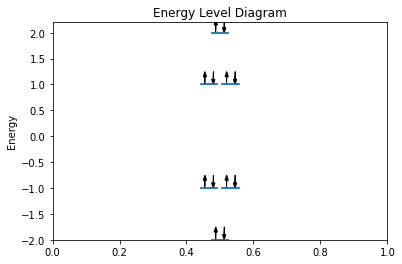

Electron energies: [-2. -2. -1. -1. -1. -1.  1.  1.  1.  1.  2.  2.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Occupation numbers: [ 2.  2.  2.  2.  2.  2.]
Total ground state energy: 0.0b


In [237]:
# Very ugly function, try to improve

# Plots energy level diagram and determines electron energies
# args: ordered list of eigenvalues, number of electrons
# rets: list of energies for the Ne electrons
def energyLevel(evals,Ne,show=True):
    
    # parameters for drawing diagram
    mid = 0.5 # midpoint
    width = 0.05 # width of each line
    space = 0.015 # spacing between lines
    arrlen = 0.15 # arrow length
    hw = 0.01 # width of head of arrow
    hl = 0.1 # length of head of arrow

    # get unique list of energies
    # returns tuple of two arrays, ([energies],[multiplicity])
    uniq = np.unique(np.around(evals,4),return_counts=True)

    energies = np.zeros(Ne) # stores energies of each electron
    occu = np.zeros(evals.size) # occupation number
    filled = 0 # keep track of how many electrons are left
    orb = 1 # keep track of current orbital
    
    for i in range(uniq[0].size): # go through each unique energy level
        E = uniq[0][i]
        m = uniq[1][i] # multiplicity
        start = mid - 0.5*(m-1)*(width+space) # where first line is drawn (left edge)
        
        turn = 1 # 1st or 2nd sweep through level
        j = 0 # keep track of degenerate energy levels
        
        while j < m:
            xL = start + j*(width+space) - 0.5*width # set bounds for drawing line
            xR = xL + width
            plt.axhline(E,xmin=xL,xmax=xR) # draw horizontal line
            if filled < Ne:
                energies[filled] = E
                if turn == 1:
                    elec = np.mean([xL,xR]) - 0.25*width
                    plt.arrow(elec,E,0,arrlen,head_width=hw,head_length=hl,fc='k',ec='k')
                    filled += 1
                    occu[orb-1] = 1
                    if j == m-1:
                        turn = 2
                        j = 0
                        orb -= (m-1)
                        continue     
                elif turn == 2:
                    elec = np.mean([xL,xR]) + 0.25*width
                    plt.arrow(elec,E+arrlen+hl,0,-arrlen,head_width=hw,head_length=hl,fc='k',ec='k')
                    filled += 1
                    occu[orb-1] = 2
                orb += 1
            j += 1
    
    plt.ylabel("Energy")
    plt.xlim([0,1])
    plt.ylim([np.min(evals),np.max(evals)+2*hl])
    plt.title("Energy Level Diagram")
    if show:
        plt.show()
        
    return energies,occu

energies,occu = energyLevel(evals,Ne)
ETot = np.sum(energies)
print("Electron energies:",energies)
print("Occupation numbers:",occu)
print("Total ground state energy:",str(ETot)+"b")


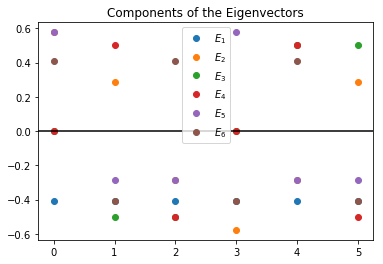

In [238]:
# Plot eigenvectors

for i in range(N):
    plt.plot(evecs[:,i],'o',label=r"$E_"+str(i+1)+"$")

plt.axhline(0,color='k')
plt.title("Components of the Eigenvectors")
plt.legend()
plt.show()

In [239]:
# Delocalization energy
# energy difference from ground state and isolated double bonds (compare to ethylene)
# 

# determine delocalization energy, given total ground state energy and number of double bonds
def calcDeloc(E,numDB):
    Ne_ethy = 2
    evals_ethy = getEigs(ethy)[0]
    E_ethy = energyLevel(evals_ethy,Ne_ethy,show=False)[0]
    ETot_ethy = np.sum(E_ethy)
    deloc = numDB*ETot_ethy - ETot

    return deloc

deloc = calcDeloc(ETot,db)

print(str(deloc)+"b")

-6.0b


In [223]:
# Charge density estimation 
# for single electron in orbital I, |c_Ir|^2 is probability of electron being on atom r

def chargeDensity(evecs,energies,occu):
    q = np.zeros(N)
        
    for r in range(N):
        c = evecs[r,:] # get the rth component of all eigenvectors
        cSq = np.square(c)
        q[r] = np.dot(cSq,occu)
    
    return q

q = chargeDensity(evecs,energies,occu)

print(q)

[ 1.  1.  1.  1.  1.  1.]


In [224]:
# Bond order calculation
# Known values:
# Butadiene - 0.89 0.45 0.89
# Benzene - 
# Toluene - 
# Naphthalene - 
# Buckyball - 

def bondOrder(adj,evecs,energies,occu):
    adjUp = np.tril(adj) # remove redundant elements
    r,s = np.nonzero(adjUp) # get indices of nonzero elements
    p = np.zeros(r.size)
    
    for i in range(r.size):
        cr = evecs[r[i],:]
        cs = evecs[s[i],:]
                
        cPr = np.multiply(cr,cs)
                
        p[i] = np.dot(cPr,occu)
    
    return p
    
p = bondOrder(adj,evecs,energies,occu)

print(p)

[ 0.667  0.667  0.667  0.667  0.667  0.667]


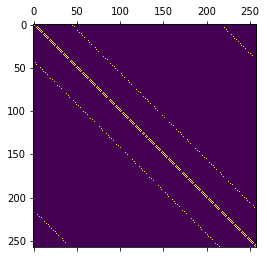

In [335]:
# Part B
# Construct adjacency matrix for graphene

# maps an (i,j) index from the square grid to the number of the atom at that location
def indexFind(i,j,rows,cols):
    i = i%cols
    j = j%rows
    return j*cols + i

# adds connection to adjacency matrix given 2 connected carbon atoms
def connect(n1,n2,adjMat):
    adjMat[n1,n2] = 1
    return

def constructZigzag(rows,cols):
    adjMat = np.zeros([rows*cols,rows*cols])
    
    for i in range(cols):
        for j in range(rows):
            cur = indexFind(i,j,rows,cols)
            
            connect(cur,indexFind(i+1,j,rows,cols),adjMat)
            connect(cur,indexFind(i-1,j,rows,cols),adjMat)
            
            if i%2 == j%2 and j != rows-1: 
                connect(cur,indexFind(i,j+1,rows,cols),adjMat)
            elif i%2 != j%2 and j != 0:
                connect(cur,indexFind(i,j-1,rows,cols),adjMat)    
    
    return adjMat


def constructArmchair(rows,cols):
    adjMat = np.zeros([rows*cols,rows*cols])
    
    for i in range(cols):
        for j in range(rows):
            cur = indexFind(i,j,rows,cols)
            
            if i != cols-1:
                connect(cur,indexFind(i+1,j,rows,cols),adjMat)
            if i != 0:
                connect(cur,indexFind(i-1,j,rows,cols),adjMat)
         
            if i%2 == j%2:
                connect(cur,indexFind(i,j+1,rows,cols),adjMat)
            else:
                connect(cur,indexFind(i,j-1,rows,cols),adjMat)    
        
    return adjMat


def constructAdj(rows,cols): 
    if rows > cols:
        adjMat = constructZigzag(rows,cols)
    else:
        adjMat = constructArmchair(rows,cols)
    return adjMat


zig = 5  # layers of hexagons connected on flat edge
arm = 21 # layers of hexagons connected in "armchair" pattern

# for zigzag configuration, use arm >> zig
# for armchair configuration, use zig >> arm

# Consider square lattice from "stretched" hex lattice
rows = zig+1  # number of rows in "stretched" square lattice
cols = arm*2 + 1  # number of columns in "stretched" square lattice

Nc = rows*cols # total number of carbon atoms
Ne = Nc # total number of pi electrons

graph = constructAdj(rows,cols) 

plt.matshow(graph)
plt.show()

[ 2.995  2.98   2.954  2.919  2.874  2.819  2.755  2.683  2.641  2.641
  2.627  2.627  2.603  2.603  2.601  2.569  2.569  2.527  2.527  2.511
  2.476  2.476  2.416  2.416  2.414  2.348  2.348  2.31   2.273  2.273
  2.199  2.19   2.19   2.101  2.101  2.081  2.006  2.006  1.958  1.907
  1.907  1.831  1.803  1.803  1.728  1.728  1.714  1.714  1.699  1.696
  1.696  1.693  1.693  1.662  1.662  1.624  1.624  1.588  1.588  1.578
  1.578  1.563  1.525  1.525  1.479  1.479  1.466  1.466  1.425  1.401
  1.401  1.371  1.371  1.332  1.332  1.285  1.267  1.267  1.259  1.259
  1.186  1.186  1.169  1.169  1.143  1.113  1.113  1.078  1.078  1.043
  1.043  1.     1.     1.     0.995  0.98   0.98   0.98   0.954  0.937
  0.937  0.927  0.927  0.919  0.892  0.892  0.889  0.889  0.874  0.869
  0.869  0.868  0.868  0.857  0.819  0.755  0.715  0.682  0.601  0.575
  0.511  0.436  0.414  0.31   0.301  0.199  0.169  0.081  0.042 -0.042
 -0.081 -0.169 -0.199 -0.301 -0.31  -0.414 -0.436 -0.511 -0.575 -0.601
 -0.68

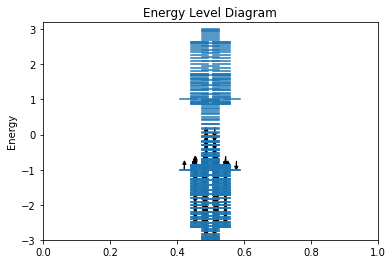

In [336]:
# Calculate eigenvalues/eigenvectors of graphene

evalsGraph,evecsGraph = getEigs(graph)
energies,occu = energyLevel(evalsGraph,Ne)

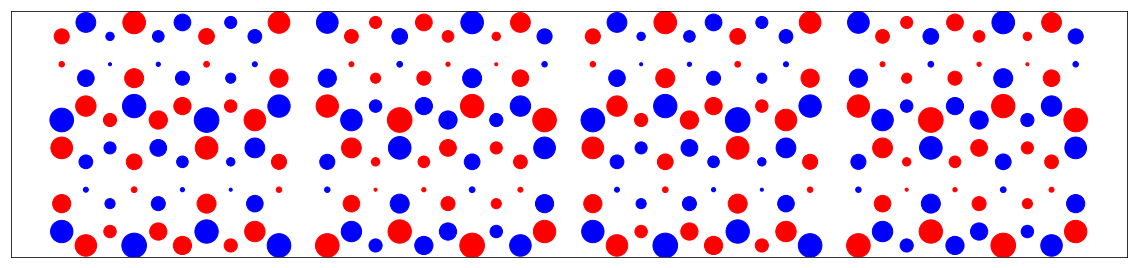

In [341]:
# drawing graphene lattice

# generate list of coordinates for each carbon
def getCoords(rows,cols):
    coords = np.zeros([rows*cols,2])
    bl = 1 # arbitrary bond length
    phi = np.pi / 6 # 
    dx = bl*np.cos(phi) # 
    dy = bl*np.sin(phi) # alternating increment in y direction along each row
    
    # for even row, initial y, y0_j = y0_j-1 - (bl + 2*dy)
    # for odd row, initial y, y0_j = y0_j-1 - bl
    # dy follows the pattern: 
    #     i%2 == j%2 -> +dy
    #     i%2 != j%2 -> -dy
    
    for j in range(rows):
        x = 0 # each row starts at x=0
        y = coords[indexFind(0,j-1,rows,cols),1] - bl
        
        if j%2 == 0: # for evens rows, increment by extra 2*dy
            y -= 2*dy
                
        for i in range(cols):
            cur = indexFind(i,j,rows,cols)
            coords[cur,0] = x
            coords[cur,1] = y
            
            x += dx
            if i%2 == j%2:
                y += dy
            else:
                y -= dy

    return coords

# calculate distance between 2 atoms
def dist(n1,n2,coords):
    x1,y1 = coords[n1,:]
    x2,y2 = coords[n2,:]
    
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

# finds the coordinates of each atom connect to a given atom
def getClosest(n,coords,adj):
    #print(coords[adj[n,:],:])
    
    return

def getColors(v,p,n):
    colors = []
    for i in range(v.size):
        if v[i] > 0:
            colors.append(p)
        else:
            colors.append(n)
    return colors
        

coords = getCoords(rows,cols)
level = 200
weights = 5000*np.abs(evecsGraph[:,level-1])

p = 'b' # color mapped to positive values 
n = 'r' # color mapped to negative values
colors = getColors(evecsGraph[:,level-1],p,n)

plt.figure(figsize=(20,10))

if zig < arm:
    plt.scatter(coords[:,0],coords[:,1],s=weights,c=colors)
else:
    plt.scatter(coords[:,1],coords[:,0],s=weights,c=color)
    
plt.axes().set_aspect('equal')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.show()